In [3]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pathlib import Path
from tqdm import tqdm

# Editing Pre-Existing Dataset

In [22]:
df = pd.read_csv("./small_dataset/other.tsv", sep='\t')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        2977 non-null   object 
 1   path             2977 non-null   object 
 2   sentence_id      2977 non-null   object 
 3   sentence         2977 non-null   object 
 4   sentence_domain  805 non-null    object 
 5   up_votes         2977 non-null   int64  
 6   down_votes       2977 non-null   int64  
 7   age              2139 non-null   object 
 8   gender           1088 non-null   object 
 9   accents          971 non-null    object 
 10  variant          0 non-null      float64
 11  locale           2977 non-null   object 
 12  segment          653 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 302.5+ KB
None


In [23]:
## Keeping only the "path" and "sentence" columns

cleaned_table = df[['path', 'sentence']]
print(cleaned_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      2977 non-null   object
 1   sentence  2977 non-null   object
dtypes: object(2)
memory usage: 46.6+ KB
None


In [24]:
cleaned_table.head()

,path,sentence
0,common_voice_zh-CN_41297646.mp3,是
1,common_voice_zh-CN_41297647.mp3,六
2,common_voice_zh-CN_41297648.mp3,五
3,common_voice_zh-CN_41320756.mp3,七
4,common_voice_zh-CN_41320758.mp3,零


In [25]:
## Only keeps 1 character values in "sentence" column

one_character_table = cleaned_table[cleaned_table['sentence'].str.len() == 1]

In [26]:
## Makes a new key column named "tone"
## Adding in tone values to each word in the "sentence" column

one_character_table.loc[:, 'tone'] = 0
one_character_table.loc[one_character_table['sentence'] == '一', 'tone'] = 1
one_character_table.loc[one_character_table['sentence'] == '八', 'tone'] = 1
one_character_table.loc[one_character_table['sentence'] == '三', 'tone'] = 1
one_character_table.loc[one_character_table['sentence'] == '六', 'tone'] = 4
one_character_table.loc[one_character_table['sentence'] == '七', 'tone'] = 1
one_character_table.loc[one_character_table['sentence'] == '五', 'tone'] = 3
one_character_table.loc[one_character_table['sentence'] == '四', 'tone'] = 4
one_character_table.loc[one_character_table['sentence'] == '九', 'tone'] = 3
one_character_table.loc[one_character_table['sentence'] == '是', 'tone'] = 4
one_character_table.loc[one_character_table['sentence'] == '零', 'tone'] = 2
one_character_table.loc[one_character_table['sentence'] == '二', 'tone'] = 4
one_character_table.loc[one_character_table['sentence'] == '否', 'tone'] = 3
one_character_table.loc[one_character_table['sentence'] == '额', 'tone'] = 2
one_character_table.loc[one_character_table['sentence'] == '打', 'tone'] = 3

/var/folders/mz/j4mj65ys7g18sp9ppmzt608c0000gn/T/ipykernel_1110/2407990490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_character_table.loc[:, 'tone'] = 0


In [27]:
## Prints the table to check for right values

unique_results = one_character_table[['sentence', 'tone']].value_counts()
print(unique_results)

sentence  tone
一         1       63
八         1       58
三         1       57
六         4       57
七         1       56
五         3       55
四         4       55
九         3       54
是         4       54
零         2       53
二         4       50
否         3       49
额         2        4
打         3        1
Name: count, dtype: int64


In [30]:
save_path = Path("./small_wav_dataset")
Path(save_path).mkdir(parents=True, exist_ok=True)

file_path = save_path / 'small_wav_dataset.csv'
one_character_table.to_csv(file_path, index=False)

# Audio Feature Extraction

In [31]:
## Function that takes in an folder and converts all mp3 files to wav

def convert_to_wav(csv_file, output_folder):
    dataset_file = pd.read_csv(csv_file)
    
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    for file_name in tqdm(dataset_file['path']):

        try:
            audio = AudioSegment.from_mp3('./small_dataset/zh-CN/clips/' + file_name)
            
            audio.export(output_folder + file_name[:-4] + ".wav", format='wav')
            ##print(f"Converting {file_name} Successful!")
            
        except Exception as err:
            ##print(f"Converting {file_name} Unsuccessful: {str(err)}")
            print(f"convert wav error {str(err)}")


In [33]:
# convert_to_wav("./small_wav_dataset/small_wav_dataset.csv", "./small_wav_dataset/wav_clips/")
# Former single threaded way




In [101]:
def visualize_tone_features(wav_path):
    """
    Visualize pitch contour, MFCCs, and energy for a single WAV file
    """
    # Load and extract features
    audio, sr = librosa.load(wav_path, sr=22050)
    
    # Create figure with 3 subplots
    plt.figure(figsize=(15, 10))
    
    # 1. Plot Pitch Contour
    plt.subplot(3, 1, 1)
    f0, voiced_flag, voiced_probs = librosa.pyin(
        audio,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7'),
        frame_length=2048
    )
    times = librosa.times_like(f0)
    plt.plot(times, f0, label='Pitch (F0)', color='blue')
    plt.title('Pitch Contour')
    plt.ylabel('Frequency (Hz)')
    plt.grid(True)
    
    # 2. Plot MFCCs
    plt.subplot(3, 1, 2)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs')
    plt.ylabel('MFCC Coefficients')
    
    # 3. Plot Energy
    plt.subplot(3, 1, 3)
    energy = librosa.feature.rms(y=audio)
    times = librosa.times_like(energy)
    plt.plot(times, energy[0], label='Energy', color='red')
    plt.title('Energy Contour')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

wav_path = "Chinese Tone Recognition /small_wav_dataset/common_voice_zh-CN_41297646.wav"
visualize_tone_features(wav_path)

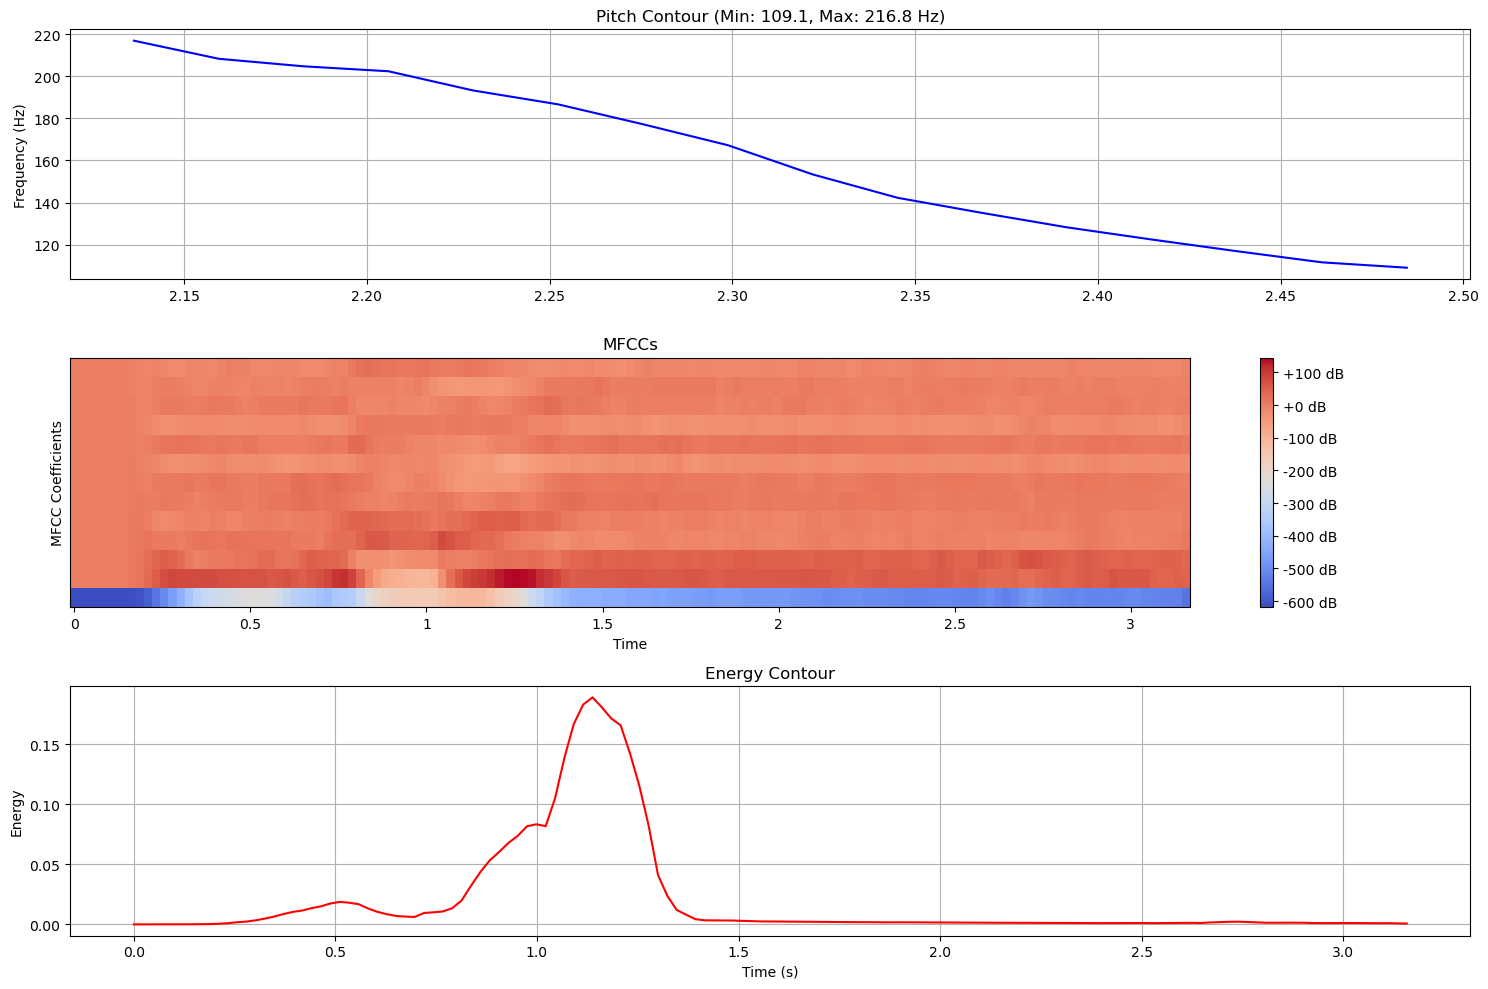

In [102]:
wav_path = "Chinese Tone Recognition /small_wav_dataset/common_voice_zh-CN_41297646.wav"
visualize_tone_features(wav_path)

In [100]:
def extract_tone_features(wav_path):
    try:
        raw_audio, sr = librosa.load(wav_path, sr=25050)
    
        ff, voiced_flag, voice_probability = librosa.pyin(raw_audio, fmin=librosa.note_to_f(C2), fmax=librosa.note_to_f(C7), frame_length = 2048)
        cleaned_ff = ff[~np.isnan[ff]]
    
        mfccs = librosa.feature.mfcc(y=raw_audio, sr=sr, n_mfcc=13)
        energy_level = librosa.feature.rms(y=audio)

        ff_norm = librosa.util.normalize(cleaned_ff)
        mfccs_norm = librosa.util.normalize(mfccs)
        energy_level_norm = librosa.util.normalize(energy_level)

        return {
            'pitch': ff_norm,
            'mfccs': mfccs_norm,
            'energy': energy_level_norm
        }
    except Exception as err:
        print("error")
        return None

In [103]:
def extract_wav_folder(wav_folder):
    folder_path = Path(wav_folder)
    features_list = []
    path_list = []

    for file_path in folder_path:
        audio_features = extract_tone_features(wav_path)
        
        if audio_features is not None:
            features_list.append(audio_features)
            path_list.append(file_path)

    return features_list, path_list